Connect to a TPU, import the required libraries and connect to the drive

In [1]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.12.0
Running on TPU  ['10.97.65.154:8470']


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import glob 
import pickle
import os
import re
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import fnmatch
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Reshape
from keras.utils import to_categorical
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers import Dropout, InputLayer, LSTM
from keras.layers import Bidirectional, BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout, UpSampling1D, AveragePooling1D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
path = '/content/drive/MyDrive/ECE542_sp2022_Project_TerrainRecognition'

In [5]:
trainData = os.listdir(f"{path}/TrainingData")[1::]
x_time_files = fnmatch.filter(trainData,'*x_time.csv')
y_time_files = fnmatch.filter(trainData,'*y_time.csv')
x_files = fnmatch.filter(trainData,'*x.csv')
y_files = fnmatch.filter(trainData,'*y.csv')

#Test Data
testData = os.listdir(f"{path}/TestData")
test_x_time_files = fnmatch.filter(testData,'*x_time.csv')
test_y_time_files = fnmatch.filter(testData,'*y_time.csv')
test_x_files = fnmatch.filter(testData,'*x.csv')

Pre-processing the data and merging

In [6]:
main_df = pd.DataFrame()
files = sorted(set([x[:14] for x in x_files]))

for file in files:
    temp_x = pd.read_csv(f"{path}/TrainingData/{file}__x.csv", names=["accr_x", "accr_y","accr_z","gyr_x","gyr_y","gyr_z"])
    temp_xt = pd.read_csv(f"{path}/TrainingData/{file}__x_time.csv", names = ["time"])
    temp_x['time'] = temp_xt['time']
    temp_x['time'] = temp_x['time'].apply(lambda x:int(x*100)/100)
    
    
    temp_y = pd.read_csv(f"{path}/TrainingData/{file}__y.csv",names=["label"])
    temp_yt = pd.read_csv(f"{path}/TrainingData/{file}__y_time.csv",names=["time"])
    temp_y['time'] = temp_yt['time']
    
    df_xy = pd.merge(temp_x,temp_y,on='time', how='outer')
    df_xy['label']= df_xy['label'].interpolate(method='pad')
    df_xy = df_xy.loc[df_xy['time']!=0]
    df = df_xy.loc[df_xy['accr_x']!='accr_x']
    main_df = main_df.append(df)

In [7]:
y = main_df['label']
x = main_df.drop('label',axis=1)
x = x.drop('time', axis=1)

One hot encoding for labels

In [8]:
y_encode = to_categorical(y,4).reshape(-1,4)
df_y = pd.DataFrame(y_encode, columns = ['label1','lable2','lable3','lable4'])

In [9]:
df_y

,label1,lable2,lable3,lable4
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
1341612,1.0,0.0,0.0,0.0
1341613,1.0,0.0,0.0,0.0
1341614,1.0,0.0,0.0,0.0
1341615,1.0,0.0,0.0,0.0


Standardize the data

In [10]:
scaler = StandardScaler()
x_scale = scaler.fit_transform(x)

In [11]:
df_x = pd.DataFrame(x_scale, columns = ['ax','ay','az','gx','gy','gz'])
print(df_x)

               ax        ay        az        gx        gy        gz
0        0.620543  0.045290 -0.567099  0.000351 -0.018272  0.083457
1        0.682938  0.054657 -0.570337  0.001033 -0.001082  0.089309
2        0.736081  0.055088 -0.568419  0.007191 -0.022229  0.069323
3        0.676755  0.012346 -0.577995  0.005263 -0.044493  0.060374
4        0.627449  0.034983 -0.577198  0.002453 -0.015124  0.065937
...           ...       ...       ...       ...       ...       ...
1341612  0.251684  0.127635 -1.716335 -0.001023 -0.014647  0.089143
1341613  0.253931  0.128546 -1.719921 -0.000847 -0.016142  0.087803
1341614  0.253695  0.127799 -1.723325 -0.002069 -0.018029  0.089157
1341615  0.258522  0.127588 -1.722741 -0.001386 -0.016478  0.090215
1341616  0.254385  0.126340 -1.719718 -0.001427 -0.016218  0.087803

[1341617 rows x 6 columns]


Performing windowing technique on train data.

In [12]:
def apply_windows(df_x, df_y, window_size=120):
  x_window, y_window=[],[]
  for i in range(0, len(df_x)-window_size, window_size+1):
    x_window.append([df_x.values[i:i+window_size]])
    y_window.append([df_y.values[i:i+window_size]])
  x_window=np.array(x_window).reshape(-1,window_size,6)
  y_window=np.array(y_window).reshape(-1,window_size,4)

  return x_window, y_window

In [13]:
window_size = 80
x, y = apply_windows(df_x, df_y, window_size)
print(x.shape, y.shape)

(16563, 80, 6) (16563, 80, 4)


Split the data into training and validation set.

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1,random_state=42)

print(len(x_train), len(x_val))
print(len(y_train), len(y_val))

14906 1657
14906 1657


In [16]:
def generate_model_CNN():
  model = Sequential()
  model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same', input_shape=(80,6)))
  model.add(AveragePooling1D(2))
  model.add(Dropout(0.2))

  model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
  model.add(AveragePooling1D(2))
  model.add(Dropout(0.2))

  model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
  model.add(UpSampling1D(size=2))
  model.add(Dropout(0.2))

  model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
  model.add(UpSampling1D(size=2))
  model.add(Dropout(0.2))

  model.add(Conv1D(4, kernel_size=3, activation='relu', padding='same'))
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=Adam(learning_rate=0.001),  loss='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [17]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  cnn_model = generate_model_CNN()
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 80, 32)            608       
                                                                 
 average_pooling1d (AverageP  (None, 40, 32)           0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)           (None, 40, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 64)            6208      
                                                                 
 average_pooling1d_1 (Averag  (None, 20, 64)           0         
 ePooling1D)                                                     
                                                                 
 dropout_1 (Dropout)         (None, 20, 64)            0

In [18]:
history_cnn= cnn_model.fit(x_train, y_train, epochs=40, verbose=1, validation_data=(x_val, y_val))

Epoch 1/40
466/466 [==============================] - 18s 23ms/step - loss: nan - accuracy: 0.7438 - val_loss: 0.6355 - val_accuracy: 0.7638
Epoch 2/40
466/466 [==============================] - 9s 19ms/step - loss: 0.6990 - accuracy: 0.7573 - val_loss: 0.6226 - val_accuracy: 0.7884
Epoch 3/40
466/466 [==============================] - 9s 19ms/step - loss: 0.6326 - accuracy: 0.7750 - val_loss: 0.5525 - val_accuracy: 0.8076
Epoch 4/40
466/466 [==============================] - 9s 20ms/step - loss: 0.6297 - accuracy: 0.7775 - val_loss: 0.5422 - val_accuracy: 0.8013
Epoch 5/40
466/466 [==============================] - 8s 18ms/step - loss: 0.6015 - accuracy: 0.7831 - val_loss: 0.5165 - val_accuracy: 0.8111
Epoch 6/40
466/466 [==============================] - 9s 19ms/step - loss: 0.5768 - accuracy: 0.7923 - val_loss: 0.5833 - val_accuracy: 0.8126
Epoch 7/40
466/466 [==============================] - 8s 18ms/step - loss: 0.5627 - accuracy: 0.7967 - val_loss: 0.4683 - val_accuracy: 0.8320
E

In [19]:
def plot_history(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='red', label='validation')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()
  plt.title('Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='red', label='validation')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()

In [20]:
def flatten_pred(y_pred):
  y_hat=[]
  for i in y_pred:
    for j in i:
      y_hat.append(np.argmax(j))
  return y_hat

In [21]:
y_val_predictions = cnn_model.predict(x_val)
y_val_predictions_flatten = flatten_pred(y_val_predictions)
y_val_flatten = flatten_pred(y_val)
print(classification_report(y_val_predictions_flatten, y_val_flatten))

52/52 [==============================] - 2s 17ms/step
              precision    recall  f1-score   support

           0       0.96      0.92      0.94    105331
           1       0.93      0.85      0.89      5873
           2       0.91      0.93      0.92      7436
           3       0.58      0.77      0.66     13920

    accuracy                           0.90    132560
   macro avg       0.84      0.87      0.85    132560
weighted avg       0.91      0.90      0.91    132560



In [51]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

In [53]:
def generate_model_biLSTM():
  model = Sequential()
  model.add(Bidirectional(LSTM(90,return_sequences=True, input_shape=(80,6))))
  model.add(Dropout(0.2))
  model.add(LSTM(40, return_sequences=True, activation="relu"))
  model.add(Dropout(0.1))
  model.add(Dense(22, activation="relu"))
  model.add(Dense(4, activation="softmax"))
  model.compile(optimizer=Adam(learning_rate=0.001),  loss='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [54]:
with tpu_strategy.scope(): 
  bilstm_model=generate_model_biLSTM()

In [55]:
# 100, 50, 25, factor 0.2
# 90, 40, 22, factor 0.5
history_bilstm = bilstm_model.fit(x_train, y_train, epochs=25, verbose=1, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/25
466/466 [==============================] - 29s 37ms/step - loss: 0.7660 - accuracy: 0.7476 - val_loss: 0.5767 - val_accuracy: 0.7892 - lr: 0.0010
Epoch 2/25
466/466 [==============================] - 14s 30ms/step - loss: 0.5877 - accuracy: 0.7974 - val_loss: 0.4753 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 3/25
466/466 [==============================] - 16s 34ms/step - loss: 0.4786 - accuracy: 0.8277 - val_loss: 0.4057 - val_accuracy: 0.8582 - lr: 0.0010
Epoch 4/25
466/466 [==============================] - 17s 36ms/step - loss: 0.3984 - accuracy: 0.8544 - val_loss: 0.3465 - val_accuracy: 0.8818 - lr: 0.0010
Epoch 5/25
466/466 [==============================] - 15s 32ms/step - loss: 0.3555 - accuracy: 0.8701 - val_loss: 0.3184 - val_accuracy: 0.8825 - lr: 0.0010
Epoch 6/25
466/466 [==============================] - 14s 31ms/step - loss: 0.3111 - accuracy: 0.8884 - val_loss: 0.3384 - val_accuracy: 0.8709 - lr: 0.0010
Epoch 7/25
466/466 [==============================] - 15s 

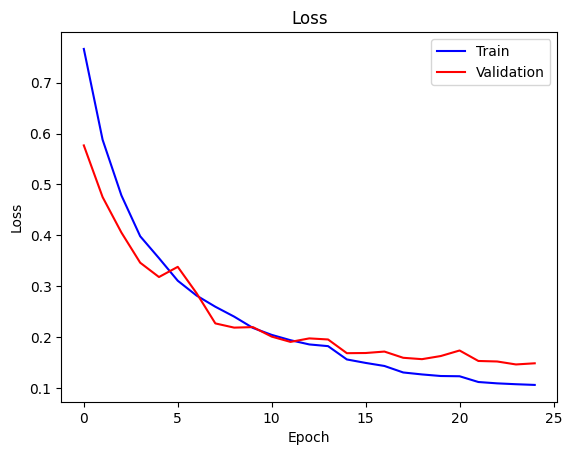

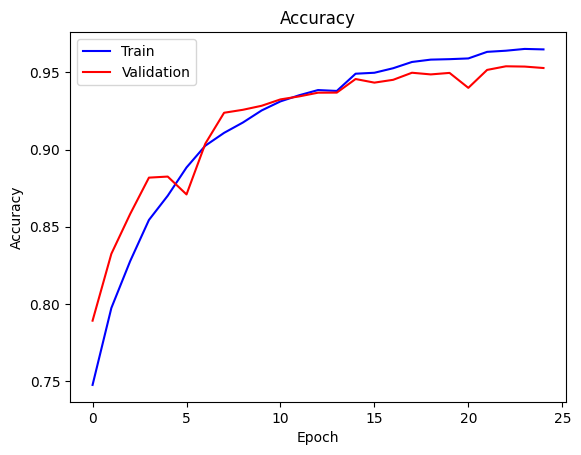

In [56]:
plot_history(history_bilstm)

In [57]:
y_val_predictions = bilstm_model.predict(x_val)
y_val_predictions_flatten = flatten_pred(y_val_predictions)
y_val_flatten = flatten_pred(y_val)
print(classification_report(y_val_predictions_flatten, y_val_flatten))

52/52 [==============================] - 4s 32ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    101518
           1       0.94      0.91      0.92      5495
           2       0.92      0.96      0.94      7231
           3       0.87      0.88      0.88     18316

    accuracy                           0.95    132560
   macro avg       0.92      0.93      0.93    132560
weighted avg       0.95      0.95      0.95    132560



Generate Test files

In [58]:
def apply_test_windows(df_x, window_size=80):
  window_x=[]
  for i in range(0, len(df_x)-window_size, window_size):
    window_x.append([df_x.values[i:i+window_size]])
  window_x=np.array(window_x).reshape(-1,window_size,6)
  return window_x

In [59]:
test_files = sorted(set([x[:14] for x in test_x_files]))
for file in test_files:
  x = pd.read_csv(f"{path}/TestData/{file}__x.csv", names=["accr_x", "accr_y","accr_z","gyr_x","gyr_y","gyr_z"])
  # x_time = pd.read_csv(f"{path}/TestData/{file}__x_time.csv", names = ["time"])
  x_test_scaled = scaler.transform(x)
  x_test = pd.DataFrame(x_test_scaled, columns = ['ax','ay','az','gx','gy','gz'])
  x = apply_test_windows(x_test, window_size) 
  y_pred = bilstm_model.predict(x)
  y = y_pred.tolist()
  yhat = flatten_pred(y)
  yhat_df=pd.DataFrame(yhat, columns=['label'])
  x = pd.read_csv(f"{path}/TestData/{file}__x.csv", names=["accr_x", "accr_y","accr_z","gyr_x","gyr_y","gyr_z"])
  x_time = pd.read_csv(f"{path}/TestData/{file}__x_time.csv", names = ["time"])
  x['time'] = x_time['time']
  x = x.join(yhat_df, how='left')
  x['label'] = x['label'].fillna(0)
  y_time = pd.read_csv(f"{path}/TestData/{file}__y_time.csv", names = ["time"])
  x['time'] = x['time'].apply(lambda x:int(x*100)/100)
  x_final= pd.merge(x, y_time, on='time', how='inner')
  x_final['label'].to_csv(f'{file}__y.csv', index=False, header=False)
  print(x_final.shape)

15/15 [==============================] - 1s 19ms/step
(9498, 8)
20/20 [==============================] - 2s 49ms/step
(12270, 8)
21/21 [==============================] - 4s 15ms/step
(12940, 8)
18/18 [==============================] - 1s 49ms/step
(11330, 8)
